<a href="https://colab.research.google.com/github/xdr100/5242_final_project/blob/main/Sample_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import tensorflow as tf

import IPython.display as display


import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

from tqdm import tqdm

In [ ]:
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim
    new_shape = tf.cast(shape * scale, tf.int32)
    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()
    plt.clf()
    plt.close()

def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [ ]:
content_layers = ['block5_conv2']
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

def extract_vgg_model(layer_names):
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([vgg.input], outputs)
    return model

def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

In [ ]:
result_path='/content/drive/My Drive/5242 advanced machine learning/project/data/'

In [ ]:
def blend_two_images(content_img_path, style_img_path, content_weight, style_weight, epoch, seed,show_every=1000):
    
    tf.random.set_seed(seed)
    # Load content and style images
    content_img = load_img(content_img_path)
    imshow(content_img, title = "Content Image")
    style_img = load_img(style_img_path)
    imshow(style_img, title = "Style Image")

    # Extract content and style models
    content_model = extract_vgg_model(content_layers)
    style_model = extract_vgg_model(style_layers)

    # Compute content and style targets
    content_targets = [x / 255 for x in content_model(tf.keras.applications.vgg19.preprocess_input(content_img * 255.0))]
    style_targets = [gram_matrix(x) / 255**2 for x in style_model(tf.keras.applications.vgg19.preprocess_input(style_img * 255.0))]
    # Initialize output image
    output_img = tf.Variable(content_img)

    # Initialize optimizer
    opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
    loss_arr = []

    # Optimize the output image
    for i in tqdm(range(epoch)):
        with tf.GradientTape() as tape:
            output_img_processed = tf.keras.applications.vgg19.preprocess_input(output_img * 255.0)
            content_outputs = [x / 255 for x in content_model(output_img_processed)]
            style_outputs = [gram_matrix(x) / 255**2 for x in style_model(output_img_processed)]
            loss = content_weight * tf.add_n([tf.reduce_mean((x - y)**2) for x,y in zip(content_outputs, content_targets)]) / num_content_layers + \
                  style_weight * tf.add_n([tf.reduce_mean((x - y)**2) for x,y in zip(style_outputs, style_targets)]) / num_style_layers
            loss_arr.append((loss.numpy() / 1 / (content_weight + style_weight)) ** 0.5)
        grad = tape.gradient(loss, output_img)
        opt.apply_gradients([(grad, output_img)])
        output_img.assign(clip_0_1(output_img))

        if (i+1) % show_every == 0: #and i > 0
            imshow(output_img, f"Blended Image\nEpoch = {i + 1}, Loss = {round(loss_arr[-1], 3)}")
            title = content_path.split('.')[0].split('/')[-1] + "_" + style_path.split('.')[0].split('/')[-1]+ "_content=" + str(content_w) + "_style=" + str(style_w) +'_seed='+str(seed)+"_after_"+str(i)+"epochs_"+ ".png"
            tensor_to_image(output_img).save(result_path + title)
        
    
    # Return the blended image
    return output_img, loss_arr

Please create a directory on the Google Drive and upload the content image and the style image to it.

In [ ]:
from google.colab import drive
drive._mount('/content/drive/')
path='/content/drive/My Drive/5242 advanced machine learning/project/data/'

Mounted at /content/drive/


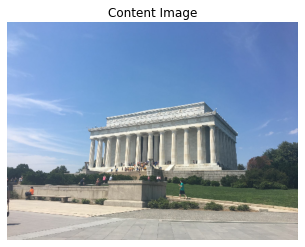

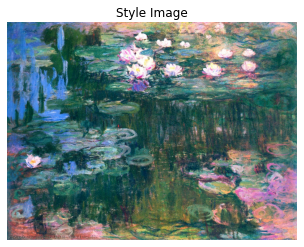

80150528/80134624 [==============================] - 3s 0us/step


 10%|▉         | 999/10000 [10:19<1:32:31,  1.62it/s]

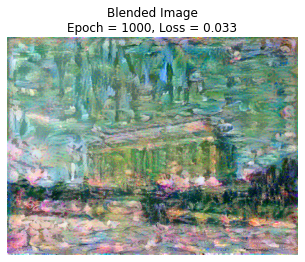

 20%|█▉        | 1999/10000 [20:38<1:22:29,  1.62it/s]

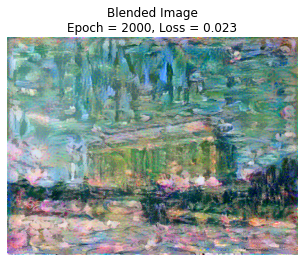

 30%|██▉       | 2999/10000 [30:57<1:12:27,  1.61it/s]

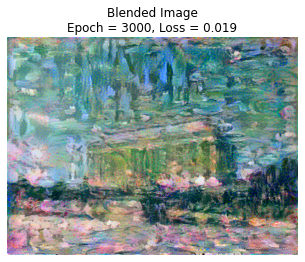

 40%|███▉      | 3999/10000 [41:16<1:01:51,  1.62it/s]

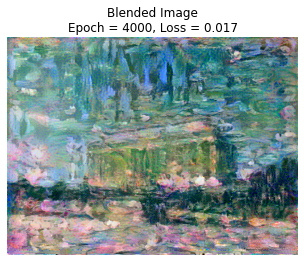

 50%|████▉     | 4999/10000 [51:36<51:44,  1.61it/s]

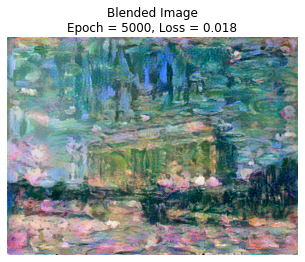

 60%|█████▉    | 5999/10000 [1:01:55<41:16,  1.62it/s]

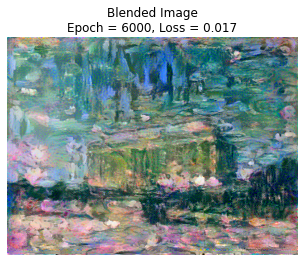

 70%|██████▉   | 6999/10000 [1:12:15<30:57,  1.62it/s]

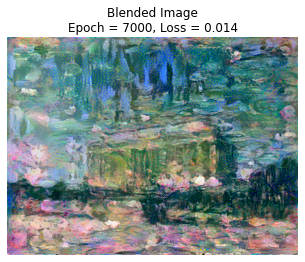

 80%|███████▉  | 7999/10000 [1:22:35<20:36,  1.62it/s]

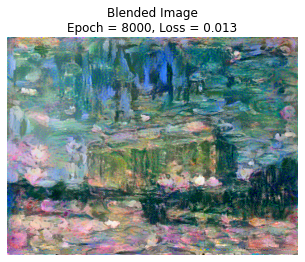

 90%|████████▉ | 8999/10000 [1:32:55<10:20,  1.61it/s]

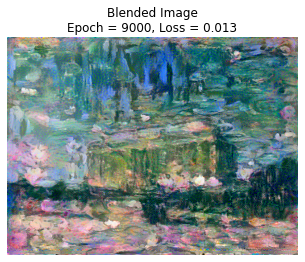

100%|█████████▉| 9999/10000 [1:43:14<00:00,  1.62it/s]

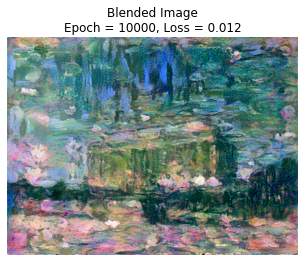

100%|██████████| 10000/10000 [1:43:15<00:00,  1.61it/s]


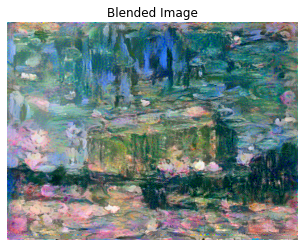

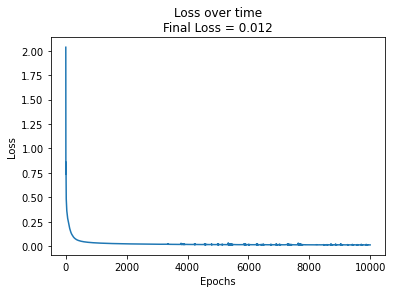

In [ ]:
seed=2021
content_img = "Washington.jpeg"
style_img = "water_lilies2.jpeg" 
content_path = path + content_img 
style_path = path + style_img 

content_w = 1e0
style_w = 1e5

blended = content_img.split(".")[0] + "_" + style_img.split(".")[0] + "_content=" + str(content_w) + "_style=" + str(style_w) +"_seed=" +str(seed)+".png"

blended_img, loss_arr = blend_two_images(content_img_path = content_path, style_img_path = style_path, content_weight = content_w, style_weight = style_w,seed=seed, epoch=10000)
imshow(blended_img, "Blended Image")
plt.plot(loss_arr)
plt.title(f"Loss over time\nFinal Loss = {round(loss_arr[-1], 3)}")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.savefig(result_path + "Loss_" + blended)
plt.show()
tensor_to_image(blended_img).save(blended)
tensor_to_image(blended_img).save(path + blended)